# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from haversine import haversine
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFECV
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

pd.options.display.max_columns = None

## Step 1: Read in Data

In [2]:
#read data and assigned column 0 as the column index
df = pd.read_csv('kc_house_data_train.csv',  index_col = 0)

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [3]:
df.head()

id             date      price  bedrooms  bathrooms  sqft_living  \
0  2591820310  20141006T000000   365000.0         4       2.25         2070   
1  7974200820  20140821T000000   865000.0         5       3.00         2900   
2  7701450110  20140815T000000  1038000.0         4       2.50         3770   
3  9522300010  20150331T000000  1490000.0         3       3.50         4560   
4  9510861140  20140714T000000   711000.0         3       2.50         2550   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      8893     2.0           0     0          4      8        2070   
1      6730     1.0           0     0          5      8        1830   
2     10893     2.0           0     2          3     11        3770   
3     14608     2.0           0     2          3     12        4560   
4      5376     2.0           0     0          3      9        2550   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1986             0    98058  47.4388 -122.162   
1           1070      1977             0    98115  47.6784 -122.285   
2              0      1997             0    98006  47.5646 -122.129   
3              0      1990             0    98034  47.6995 -122.228   
4              0      2004             0    98052  47.6647 -122.083   

   sqft_living15  sqft_lot15  
0           2390        7700  
1           2370        6283  
2           3710        9685  
3           4050       14226  
4           2250        4050

In [4]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [5]:
df.shape

(17290, 21)

In [6]:
#Checking for null values. No null values identified
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

In [8]:
#Transformed date column to Pandas datetime format
df['date'] = pd.to_datetime(df.date)

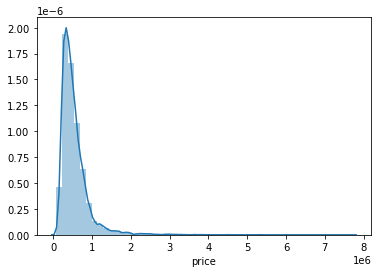

In [9]:
#checking for normality of target variable
sns.distplot(df.price) #take log of price. Check log rmse vs non-log

In [10]:
#numerical features
numerical = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long','sqft_living15', 'sqft_lot15'] #removed lat and long

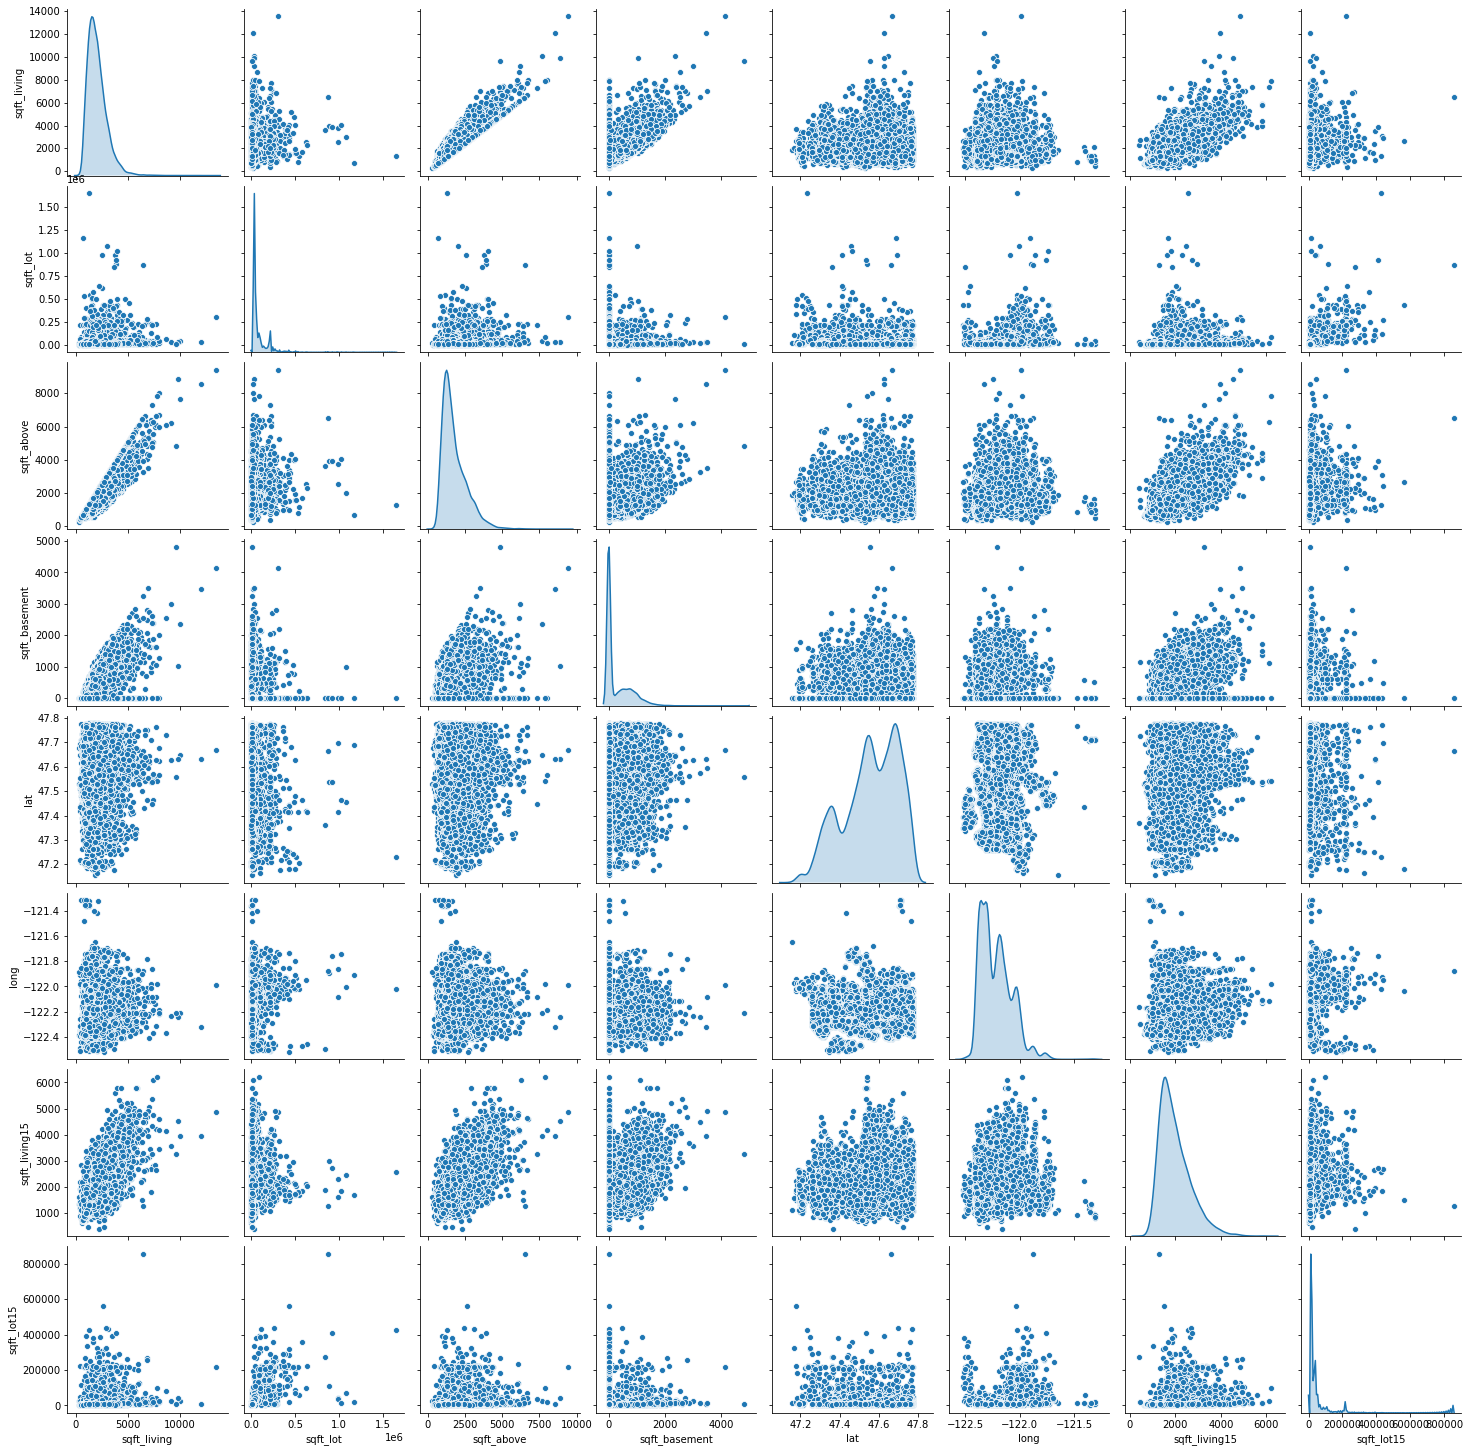

In [11]:

sns.pairplot(df[numerical], diag_kind='kde', height=2.5)

In [12]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  1.729000e+04  1.729000e+04  17290.000000  17290.000000  17290.000000   
mean   4.565502e+09  5.407395e+05      3.372470      2.111943   2081.464604   
std    2.874656e+09  3.733190e+05      0.939346      0.770476    920.018539   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.114701e+09  3.210000e+05      3.000000      1.500000   1430.000000   
50%    3.903650e+09  4.500000e+05      3.000000      2.250000   1920.000000   
75%    7.301150e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  1.729000e+04  17290.000000  17290.000000  17290.000000  17290.000000   
mean   1.524340e+04      1.490312      0.007981      0.238519      3.408502   
std    4.230462e+04      0.538909      0.088985      0.775229      0.651296   
min    5.720000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.081250e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.642000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.072575e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  17290.000000  17290.000000   17290.000000  17290.000000  17290.000000   
mean       7.654425   1789.306015     292.158589   1970.792019     83.806304   
std        1.174718    829.265107     443.151874     29.343516    400.329376   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1200.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1974.000000      0.000000   
75%        8.000000   2214.500000     560.000000   1996.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  17290.000000  17290.000000  17290.000000   17290.000000   17290.000000  
mean   98078.193175     47.560058   -122.214258    1987.986698   12873.475824  
std       53.607949      0.138412      0.140857     684.802635   27227.437583  
min    98001.000000     47.155900   -122.519000     399.000000     659.000000  
25%    98033.000000     47.471200   -122.329000    1490.000000    5111.250000  
50%    98065.000000     47.571600   -122.230000    1840.000000    7622.500000  
75%    98118.000000     47.677900   -122.126000    2360.000000   10101.750000  
max    98199.000000     47.777600   -121.315000    6210.000000  858132.000000

## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [13]:
df[df.bathrooms == 0]

id       date      price  bedrooms  bathrooms  sqft_living  \
483    3374500520 2015-04-29   355000.0         0        0.0         2460   
1120   6306400140 2014-06-12  1095000.0         0        0.0         3064   
3032   7849202190 2014-12-23   235000.0         0        0.0         1470   
5424   3918400017 2015-02-05   380000.0         0        0.0         1470   
9060   3421079032 2015-02-17    75000.0         1        0.0          670   
9286   2954400190 2014-06-24  1295650.0         0        0.0         4810   
10067  3980300371 2014-09-26   142000.0         0        0.0          290   
12982   203100435 2014-09-18   484000.0         1        0.0          690   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
483        8049     2.0           0     0          3      8        2460   
1120       4764     3.5           0     2          3      7        3064   
3032       4800     2.0           0     0          3      7        1470   
5424        979     3.0           0     2          3      8        1470   
9060      43377     1.0           0     0          3      3         670   
9286      28008     2.0           0     0          3     12        4810   
10067     20875     1.0           0     0          1      1         290   
12982     23244     1.0           0     0          4      7         690   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
483                0      1990             0    98031  47.4095 -122.168   
1120               0      1990             0    98102  47.6362 -122.322   
3032               0      1996             0    98065  47.5265 -121.828   
5424               0      2006             0    98133  47.7145 -122.356   
9060               0      1966             0    98022  47.2638 -121.906   
9286               0      1990             0    98053  47.6642 -122.069   
10067              0      1963             0    98024  47.5308 -121.888   
12982              0      1948             0    98053  47.6429 -121.955   

       sqft_living15  sqft_lot15  
483             2520        8050  
1120            2360        4000  
3032            1060        7200  
5424            1470        1399  
9060            1160       42882  
9286            4740       35061  
10067           1620       22850  
12982           1690       19290

In [14]:
# Corrected all homes with 0 bedrooms and 0 bathrooms with a sqft living over 1,400. Therese were likely data errors.


# Replaced 0 bedrooms with 4
df['bedrooms'] = np.where(((df.sqft_living > 1400) & (df.bedrooms == 0)), 4, df.bedrooms)

# Replaced 0 bathrooms with 3
df['bathrooms'] = np.where(((df.sqft_living > 1400) & (df.bathrooms == 0)), 3, df.bathrooms)

In [15]:
# inspecting home with the 33 bedrooms.
df.loc[df.bedrooms == 33, :]

id       date     price  bedrooms  bathrooms  sqft_living  \
8597  2402100895 2014-06-25  640000.0        33       1.75         1620   

      sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
8597      6000     1.0           0     0          5      7        1040   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
8597            580      1947             0    98103  47.6878 -122.331   

      sqft_living15  sqft_lot15  
8597           1330        4700

In [16]:
# inspecting home with the 11 bedrooms.
df.loc[df.bedrooms == 11, :]

id       date     price  bedrooms  bathrooms  sqft_living  \
2356  1773100755 2014-08-21  520000.0        11        3.0         3000   

      sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
2356      4960     2.0           0     0          3      7        2400   

      sqft_basement  yr_built  yr_renovated  zipcode     lat     long  \
2356            600      1918          1999    98106  47.556 -122.363   

      sqft_living15  sqft_lot15  
2356           1420        4960

In [17]:
#replaced 33 with 3 bedrooms after  checking property in Zillow page.
df['bedrooms'] = df.bedrooms.replace({33:3})

#replaced 11 with 4 bedrooms after  checking property in Zillow page.
df['bedrooms'] = df.bedrooms.replace({11:4})

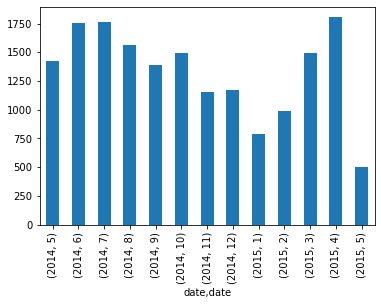

In [18]:
#Count of houses sold by year and month. Checking for sales trend overtime in King County.
df.groupby([df.date.dt.year, df.date.dt.month]).price.count().plot(kind='bar')

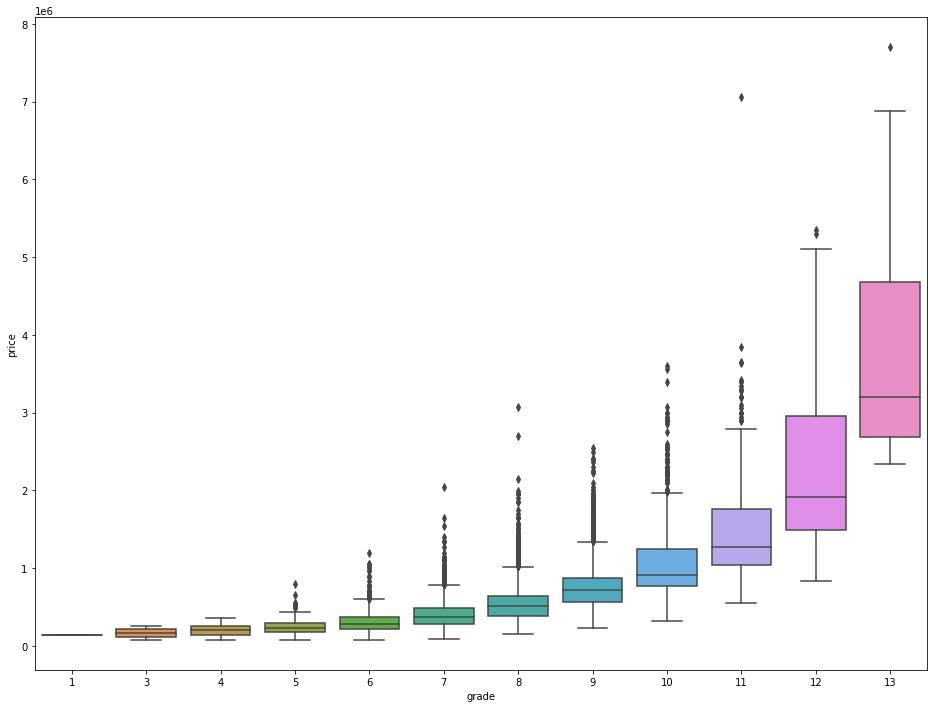

In [19]:
# this plot demontrates a clear positive relationship between grade and home prices.
plt.figure(figsize=(16,12))
sns.boxplot(x='grade', y='price', data=df)

In [20]:
#outlier - legitamate because of features such as  number of bedrooms, bathrooms, floors, etc
df[df.grade == 11].price.max()
df[df.price == 7062500.0]

id       date      price  bedrooms  bathrooms  sqft_living  \
6903  9808700762 2014-06-11  7062500.0         5        4.5        10040   

      sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
6903     37325     2.0           1     2          3     11        7680   

      sqft_basement  yr_built  yr_renovated  zipcode    lat     long  \
6903           2360      1940          2001    98004  47.65 -122.214   

      sqft_living15  sqft_lot15  
6903           3930       25449

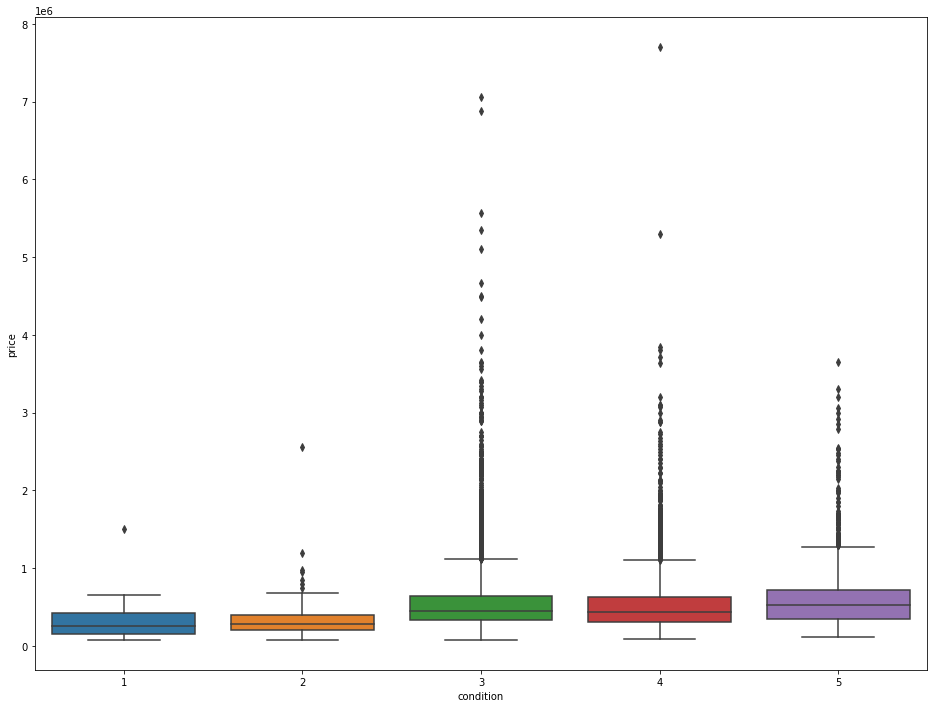

In [21]:
plt.figure(figsize=(16,12))
sns.boxplot(x='condition', y='price', data=df)

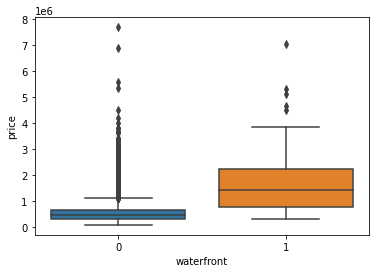

In [22]:
sns.boxplot(x='waterfront', y='price', data=df)

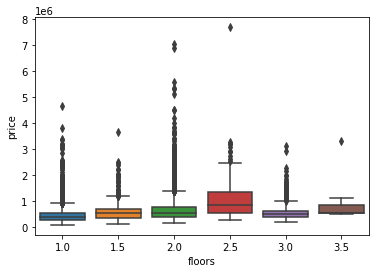

In [23]:
sns.boxplot(x='floors', y='price', data=df)

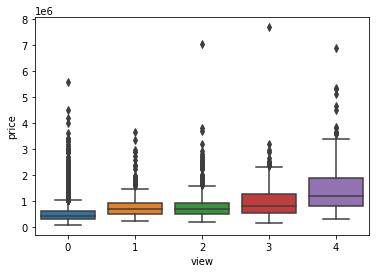

In [24]:
sns.boxplot(x='view', y='price', data=df)

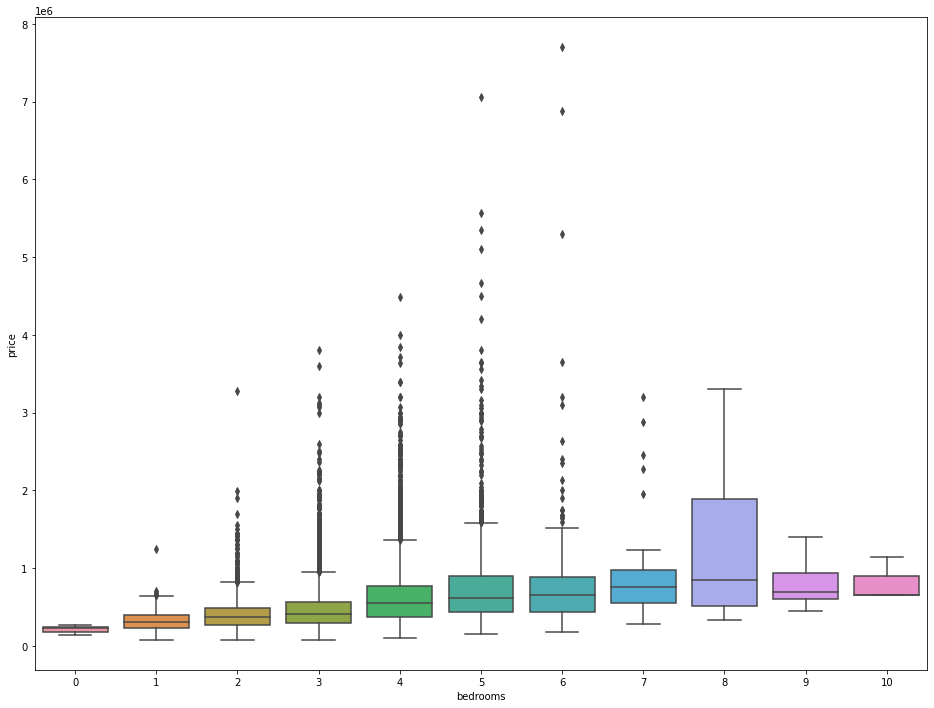

In [25]:
plt.figure(figsize=(16,12))
sns.boxplot(x='bedrooms', y='price', data=df)

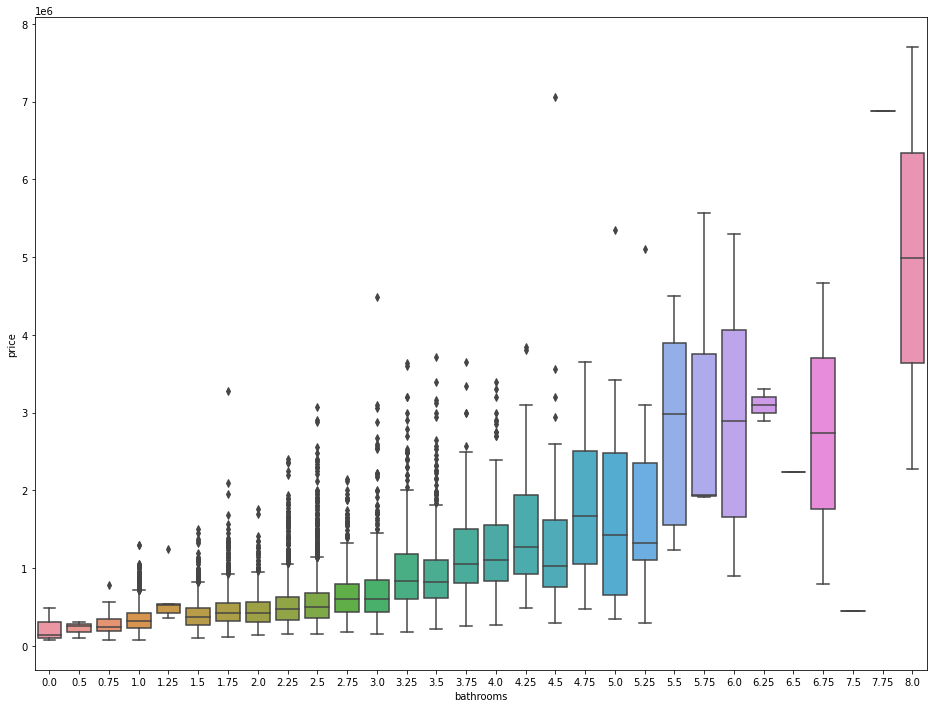

In [26]:
plt.figure(figsize=(16,12))
sns.boxplot(x='bathrooms', y='price', data=df)

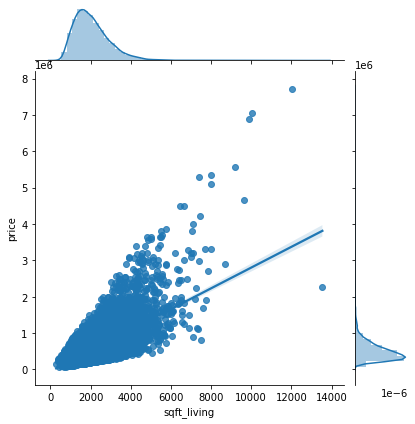

In [27]:
sns.jointplot('sqft_living', 'price', data=df, kind='reg' )

In [28]:
df[df.sqft_living > 12000]

id       date      price  bedrooms  bathrooms  sqft_living  \
3275   1225069038 2014-05-05  2280000.0         7        8.0        13540   
10366  6762700020 2014-10-13  7700000.0         6        8.0        12050   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
3275     307752     3.0           0     4          3     12        9410   
10366     27600     2.5           0     3          4     13        8570   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
3275            4130      1999             0    98053  47.6675 -121.986   
10366           3480      1910          1987    98102  47.6298 -122.323   

       sqft_living15  sqft_lot15  
3275            4850      217800  
10366           3940        8800

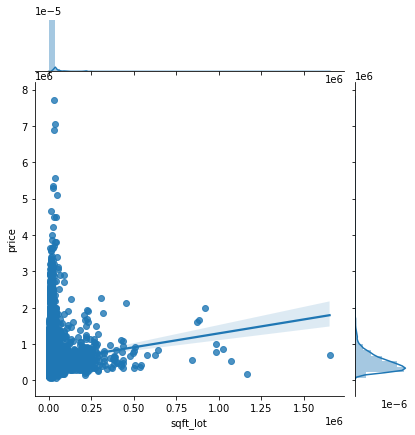

In [29]:
sns.jointplot('sqft_lot', 'price', data=df, kind='reg' )

In [30]:
df[df.sqft_lot == 1651359]

id       date     price  bedrooms  bathrooms  sqft_living  \
718  1020069017 2015-03-27  700000.0         4        1.0         1300   

     sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
718   1651359     1.0           0     3          4      6        1300   

     sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
718              0      1920             0    98022  47.2313 -122.023   

     sqft_living15  sqft_lot15  
718           2560      425581

In [31]:
#use np.where to replace all sqft_lot above 650,00 with 650,000
df['sqft_lot'] = np.where(df.sqft_lot > 650000, 650000, df.sqft_lot)

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [32]:
#Defining groups of the grade feature as 1 to 5, 6, 7, 8, 9, 10, and 11 to 13
np.sort(df.grade.unique())

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int64)

In [33]:
conditions = [
    ((df.grade >=1) & (df.grade <=5)),
    df.grade == 6,
    df.grade == 7,
    df.grade == 8,
    df.grade == 9,
    df.grade == 10,
    ((df.grade >=11) & (df.grade <=13))
]

choices = [
    1,
    2,
    3,
    4,
    5,
    6,
    7    
]

df['grade_new'] = np.select(conditions, choices)

In [34]:
#Computing the distancing of properties from the main cities' hub, including seattle and bellevue. The closer a properties location is to city hubs, the more expensive it is likely to be.
df['lat_long'] = tuple(zip(df.lat,df.long))
seattle = [47.6092, -122.3363]
bellevue = [47.61555, -122.20392]

In [35]:
seattle_distances = []
for i in df['lat_long']:
    seattle_distances.append(haversine((seattle), (i), unit = 'mi'))
df['distance_from_seattle'] = pd.Series(seattle_distances)

bellevue_distances = []
for i in df['lat_long']:
    bellevue_distances.append(haversine((bellevue), (i), unit = 'mi'))
df['distance_from_bellevue'] = pd.Series(bellevue_distances)

In [36]:
df['distance_from_epicenter'] = df[['distance_from_bellevue', 'distance_from_seattle']].min(axis=1)

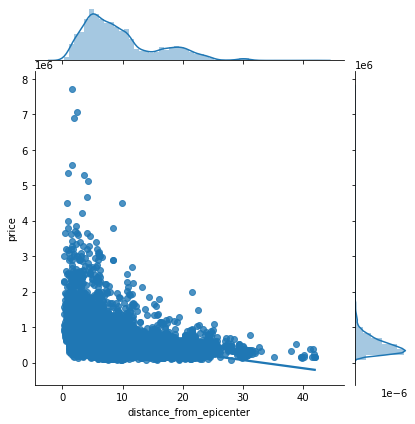

In [37]:
sns.jointplot('distance_from_epicenter', 'price', data=df, kind='reg')

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [38]:
# Zip code dummies and droped 1 column 98103
df_dummy = pd.get_dummies(df.zipcode).drop(columns = 98103)
df = pd.concat([df, df_dummy], 1)

In [39]:
df.head()

id       date      price  bedrooms  bathrooms  sqft_living  \
0  2591820310 2014-10-06   365000.0         4       2.25         2070   
1  7974200820 2014-08-21   865000.0         5       3.00         2900   
2  7701450110 2014-08-15  1038000.0         4       2.50         3770   
3  9522300010 2015-03-31  1490000.0         3       3.50         4560   
4  9510861140 2014-07-14   711000.0         3       2.50         2550   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      8893     2.0           0     0          4      8        2070   
1      6730     1.0           0     0          5      8        1830   
2     10893     2.0           0     2          3     11        3770   
3     14608     2.0           0     2          3     12        4560   
4      5376     2.0           0     0          3      9        2550   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1986             0    98058  47.4388 -122.162   
1           1070      1977             0    98115  47.6784 -122.285   
2              0      1997             0    98006  47.5646 -122.129   
3              0      1990             0    98034  47.6995 -122.228   
4              0      2004             0    98052  47.6647 -122.083   

   sqft_living15  sqft_lot15  grade_new             lat_long  \
0           2390        7700          4  (47.4388, -122.162)   
1           2370        6283          4  (47.6784, -122.285)   
2           3710        9685          7  (47.5646, -122.129)   
3           4050       14226          7  (47.6995, -122.228)   
4           2250        4050          5  (47.6647, -122.083)   

   distance_from_seattle  distance_from_bellevue  distance_from_epicenter  \
0              14.309139               12.367875                12.367875   
1               5.344465                5.753383                 5.344465   
2              10.140076                4.957910                 4.957910   
3               8.020773                5.907657                 5.907657   
4              12.400666                6.574320                 6.574320   

   98001  98002  98003  98004  98005  98006  98007  98008  98010  98011  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      1      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   98014  98019  98022  98023  98024  98027  98028  98029  98030  98031  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   98032  98033  98034  98038  98039  98040  98042  98045  98052  98053  \
0      0      0      0      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      1      0   

   98055  98056  98058  98059  98065  98070  98072  98074  98075  98077  \
0      0      0      1      0      0      0      0      0      0      0   
1      0      0      0      0      0      0      0      0      0      0   
2      0      0      0      0      0      0      0      0      0      0   
3      0      0      0      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      0      0      0   

   98092  98102  98105  98106  98107  98108  98109  98112  98115  

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

In [40]:
#your code here

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [41]:
df['age'] = 2016 - df.yr_built

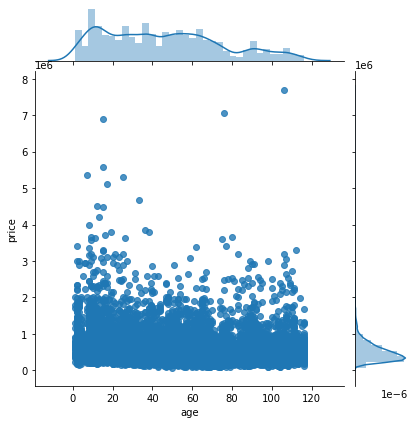

In [42]:
sns.jointplot('age', 'price', data=df, kind='reg' )

In [43]:
df.yr_renovated.value_counts()

0       16564
2014       71
2007       32
2005       32
2000       31
        ...  
1934        1
1959        1
1944        1
1951        1
1948        1
Name: yr_renovated, Length: 69, dtype: int64

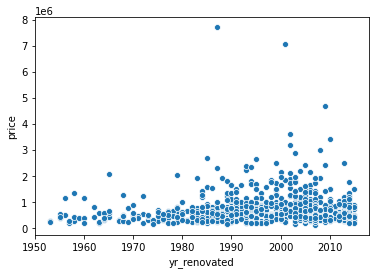

In [44]:


#sns.scatterplot(data=df, x=(df.yr_renovated > 1970), y='price')

rect_ren=df[df.yr_renovated > 1951]
sns.scatterplot(data=rect_ren, x='yr_renovated', y='price')

In [45]:
df['renovated_flg'] = np.where(df.yr_renovated == 0, 1, 0)

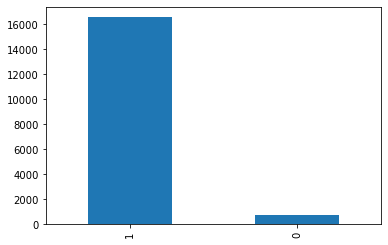

In [46]:
df.renovated_flg.value_counts().plot(kind='bar')

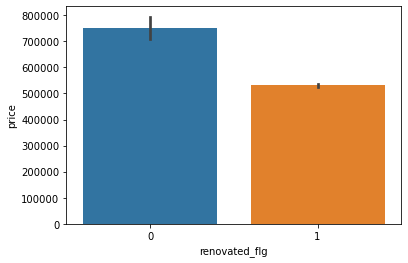

In [47]:
sns.barplot(x='renovated_flg', y='price', data=df )

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [50]:
# your code here
df_features = df.loc[:, ~df.columns.isin(['id','date', 'price', 'distance_from_seattle', 'distance_from_bellevue', 'lat_long', 'zipcode'])]
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 90 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bedrooms                 17290 non-null  int64  
 1   bathrooms                17290 non-null  float64
 2   sqft_living              17290 non-null  int64  
 3   sqft_lot                 17290 non-null  int64  
 4   floors                   17290 non-null  float64
 5   waterfront               17290 non-null  int64  
 6   view                     17290 non-null  int64  
 7   condition                17290 non-null  int64  
 8   grade                    17290 non-null  int64  
 9   sqft_above               17290 non-null  int64  
 10  sqft_basement            17290 non-null  int64  
 11  yr_built                 17290 non-null  int64  
 12  yr_renovated             17290 non-null  int64  
 13  lat                      17290 non-null  float64
 14  long                  

In [ ]:
df_features_con = df_features[]

In [49]:
[x for x in df_features.columns if x not in c]

NameError: name 'c' is not defined

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)

In [ ]:
poly_data = poly.fit_transform(df_features)

In [ ]:
poly_data.shape

In [ ]:
df_features.columns = df_features.columns.map(str)
poly_columns = poly.get_feature_names(df_features.columns)

In [ ]:
df_poly = pd.DataFrame(poly_data, columns=poly_columns)

In [ ]:
df_poly.head()

In [ ]:
# polynomials for only continues variables


### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [ ]:
# your code here

## Step 5: Train-Test Split

If you plan on doing any scaling of your data, make sure it is done at the appropriate time. 

### 5.1) Perform a train-test split of the data.

In [ ]:
#call train_test_split on the data and capture the results
target = df.price

#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(df_poly, target, random_state=34, test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

### 5.2) Fit your scaler to training the data.

In [ ]:
scaler = StandardScaler()
target_log = np.log(df.price)

# Did a seperate train, test, split on the loged tarted, and then I scalled the train and test data.
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_poly, target_log, random_state=34, test_size=0.2)

#fit and transform the training data
X_train1 = pd.DataFrame(data=scaler.fit_transform(X_train1), columns=df_poly.columns)

### 5.3) Transform the testing set with the scaler.

In [ ]:
#transferm the testing data
X_test1 = pd.DataFrame(data=scaler.transform(X_test1), columns=df_poly.columns)


### 5.4) Fit the model to the training data.

In [ ]:
#instantiate a linear regression object
linreg = LinearRegression()

#fit the linear regression to the data
linreg = linreg.fit(X_train, y_train)

print(linreg.intercept_)
print(linreg.coef_)

In [ ]:
#pairing the feature names with the coefficients
list(zip(df_poly.columns, linreg.coef_))

### 5.5) Use the model to predict on the training set and the test set.

In [ ]:
#your code here 
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [ ]:
#your code here 

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training: ', int(train_rmse), 'vs. Testing', int(test_rmse))

### 5.7) Determine if your model is overfit.

In [ ]:
#your code here 
sns.residplot(x = y_test, y=y_test_pred, lowess=True, color = 'g')

In [ ]:
plt.hist(y_test - y_test_pred)

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [ ]:
# Check VIF of features

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(df_features.values, i) for i in range(df_features.shape[1])]
vif['features'] = df_features.columns
vif.sort_values(by='VIF Factor', ascending=False).head(20)

In [ ]:
X_train.shape

In [ ]:
selector = SelectKBest(f_regression, k=50)

selector.fit(X_train, y_train)

In [ ]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [ ]:
list(removed_columns)

In [ ]:
list(selected_columns)

In [ ]:
# Recursive feature Selection

ols = LinearRegression()

selector = RFECV(estimator=ols, step=1, cv=7, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

selector.fit(X_train[selected_columns], y_train)

In [ ]:
selected_rfe = X_train[selected_columns].columns[selector.support_]
removed_rfe = X_train[selected_columns].columns[~selector.support_]

In [ ]:
selected_rfe

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [ ]:
#instantiate a linear regression object
linreg_kbest = LinearRegression()

#fit the linear regression to the data
linreg_kbest.fit(X_train1[selected_columns], y_train1)

y_train_kbest = linreg_kbest.predict(X_train1[selected_columns])

trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train1, y_train_kbest))

print('Training Root Mean Squared Error: ', trainK_rmse)

y_test_kbest = linreg_kbest.predict(X_test1[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test1, y_test_kbest))

print('Testing Root Mean Squared Error: ', testK_rmse)

In [ ]:
#exponentiating RMSE value
trainK_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train1), np.exp(y_train_kbest)))
trainK_rmse

In [ ]:
#exponentiating RMSE value
testK_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test1), np.exp(y_test_kbest)))
testK_rmse

In [ ]:
sns.residplot(x = y_test1, y=y_test_kbest, lowess=True, color = 'g')

In [ ]:
# Recursive feature Selection fit
linreg_rfe = LinearRegression()

linreg_rfe = linreg_rfe.fit(X_train1[selected_rfe], y_train1)

y_rfe = linreg_rfe.predict(X_train1[selected_rfe])

trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train1, y_rfe))

print('Training Rood Mean Squared Error: ', trainRFE_rmse)

y_pred_rfe = linreg_rfe.predict(X_test1[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test1, y_pred_rfe))

print('Testing Root Mean Squared Error: ', testRFE_rmse)

In [ ]:
#exponentiating RMSE value
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train1), np.exp(y_rfe)))
trainRFE_rmse

In [ ]:
#exponentiating RMSE value
testRFE_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test1), np.exp(y_pred_rfe)))
testRFE_rmse

In [ ]:
sns.residplot(x = y_test, y=y_pred_rfe, lowess=True, color = 'g')

In [ ]:
lasso = Lasso(alpha=0.01, normalize=False)

lasso = lasso.fit(X_train1[selected_rfe], y_train1)

y_train_pred_lasso = lasso.predict(X_train1[selected_rfe])
y_pred_lasso = lasso.predict(X_test1[selected_rfe])

train_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(y_train1, y_train_pred_lasso))
test_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(y_test1, y_pred_lasso))

print('Training Error: ' + str(train_rmse_lasso01))
print('Testing Error: ' + str(test_rmse_lasso01))

In [ ]:
f =  lasso.coef_ != 0
f.sum()

In [ ]:
train_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(np.exp(y_train1), np.exp(y_train_pred_lasso)))
train_rmse_lasso01

In [ ]:
test_rmse_lasso01 = np.sqrt(metrics.mean_absolute_error(np.exp(y_test1), np.exp(y_pred_lasso)))
test_rmse_lasso01

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.00001, normalize=False)

ridge = ridge.fit(X_train1[selected_rfe], y_train1)

y_train_pred_ridge = ridge.predict(X_train1[selected_rfe])
y_pred_ridge = ridge.predict(X_test1[selected_rfe])

train_rmse_ridge = np.sqrt(metrics.mean_squared_error(np.exp(y_train1), np.exp(y_train_pred_ridge)))
test_rmse_ridge = np.sqrt(metrics.mean_squared_error(np.exp(y_test1), np.exp(y_pred_ridge)))

print('Training Error: ' + str(train_rmse_ridge))
print('Testing Error: ' + str(test_rmse_ridge))

In [ ]:
sns.residplot(x = y_test1, y=y_pred_ridge, lowess=True, color = 'g')

## Step 7: Evaluate your different models in order to determine the best model overall.

In [ ]:
print('Model 1: Training RMSE: ', int(train_rmse), 'vs. Testing RMSE: ', int(test_rmse), '- No feature selection or scaling')
print('\nModel 2: Training RMSE: ', str(round(trainK_rmse, 3)), 'vs. Testing RMSE: ', str(round(testK_rmse, 3)), '- Kbest feature selection, target log and scaling')
print('\nModel 3: Training RMSE: ', str(round(trainRFE_rmse, 3)), 'vs. Testing RMSE: ', str(round(testRFE_rmse, 3)), '- Recursive feature selection, target log and scaling')
print('\nModel 4: Training RMSE: ', str(round(train_rmse_ridge, 3)), 'vs. Testing RMSE: ', str(round(test_rmse_ridge, 3)), '- kbest feature selection, Ridge , target log and scaling')

## Step 8:  Refit your best model to the entire dataset.

In [ ]:
linreg_final = LinearRegression()

linreg_final = linreg.fit(df_poly, df['price'])

In [ ]:
linreg_final.coef_

In [ ]:
final_scaler =StandardScaler()

#fit and transform the training data
df_final_scaled = pd.DataFrame(data=final_scaler.fit_transform(df_poly[selected_rfe]), columns=selected_rfe)

In [ ]:
linreg_ridge_final = LinearRegression()

linreg_ridge_final = linreg_ridge_final.fit(df_final_scaled, df['price'])

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
import pickle

pickle_out = open("model01.pickle", "wb")
pickle.dump(linreg_final, pickle_out)
pickle_out.close()

In [ ]:
#import pickle

#pickle_out = open("ridge_model.pickle", "wb")
#pickle.dump(linreg_ridge_final, pickle_out)
#pickle_out.close()

In [ ]:
#pickle_out = open('scaler.pickle', "wb")
#pickle.dump(final_scaler, pickle_out)
#pickle_out.close()